### Load Data

conda activate preprocess_data

In [1]:
import glob
import sys
import os
import re
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random

folder_path = r"/home/durrlab-asong/Anthony/virtual_staining_processing_inference_functions"
sys.path.append(folder_path)
from processing_functions import *


## Break up BIT and MUSE images into training patches. 

### Load Data

#### Crop Video to remove artifact region. 

In [2]:
import numpy as np

def crop_3d(img: np.ndarray, top_left: tuple, bottom_right: tuple) -> np.ndarray:
    """
    Crop a rectangular region across the entire volume using top-left and bottom-right coordinates.

    Supports:
      - 2D grayscale: (H, W)
      - 3D grayscale stack: (Z, H, W)
      - 4D with singleton channel: (Z, 1, H, W)

    Crops along the last two axes (Y=H, X=W) and preserves all leading axes (e.g., Z).

    Args:
        img (np.ndarray): Input array.
        top_left (tuple): (x1, y1) coordinates of the top-left corner.
        bottom_right (tuple): (x2, y2) coordinates of the bottom-right corner.

    Returns:
        np.ndarray: Cropped array view (use .copy() if you need a copy).
    """
    x1, y1 = top_left
    x2, y2 = bottom_right

    # Spatial dimensions are the last two axes
    H = img.shape[-2]
    W = img.shape[-1]

    # Clip to bounds
    x1 = max(0, min(W, x1))
    x2 = max(0, min(W, x2))
    y1 = max(0, min(H, y1))
    y2 = max(0, min(H, y2))

    if x2 <= x1 or y2 <= y1:
        raise ValueError(f"Invalid crop box: ({x1},{y1}) to ({x2},{y2})")

    # Build slice: keep all leading axes, crop last two (Y, X)
    prefix = (slice(None),) * (img.ndim - 2)
    return img[prefix + (slice(y1, y2), slice(x1, x2))]

Number of BIT files found: 3
(46, 1302, 1866)


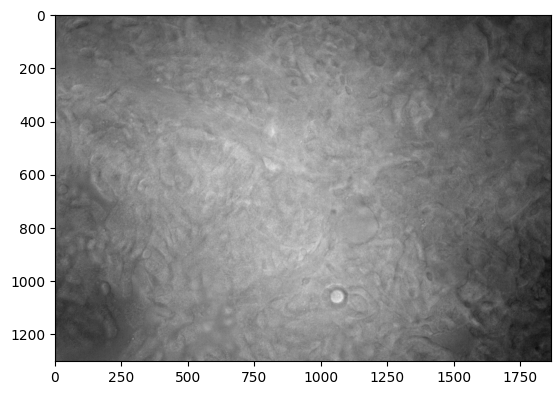

In [ ]:
# Load files
root = r'C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\BIT\train\crypts'
BIT_tif_files = glob.glob(os.path.join(root, '*BIT*.tif'))


print("Number of BIT files found:", len(BIT_tif_files))

# Rectangular Crop Parameters: 
x_1 = 324
y_1 = 548
x_2 = 2190
y_2 = 1850
top_left = (x_1, y_1)
bottom_right = (x_2, y_2)
start_z = 24
end_z = 69
file_number = '0015'
tissue_type = 'submucosa'

path = os.path.join(root, "submucosa_Duodenum_BIT_40X_PiezoScan_SprayPaintedAdapters_DelZ0p5um_Range25um_IM0015_frame24-69.tif")
stack = tiff.imread(path)
cropped_stack = crop_3d(stack, top_left, bottom_right)
cropped_cut_stack = cropped_stack[start_z:end_z+1]
print(cropped_cut_stack.shape)
plt.imshow(cropped_cut_stack[0], cmap='gray')
plt.show()
save_path = os.path.join(root, 'crop')
if not os.path.exists(save_path):
    os.makedirs(save_path)
tiff.imwrite(os.path.join(save_path, f'{tissue_type}_Duodenum_IM{file_number}_cropped_BIT_40X_frame{start_z}-{end_z}.tif'), cropped_cut_stack)

In [20]:
import os
from glob import glob
from PIL import Image
import numpy as np

def crop_image(img: np.ndarray, top_left: tuple, bottom_right: tuple) -> np.ndarray:
    """
    Crop a rectangular region from the image using top-left and bottom-right coordinates.

    Args:
        img (np.ndarray): Input image (2D grayscale or 3D color).
        top_left (tuple): (x1, y1) coordinates of the top-left corner.
        bottom_right (tuple): (x2, y2) coordinates of the bottom-right corner.

    Returns:
        np.ndarray: Cropped image.
    """
    x1, y1 = top_left
    x2, y2 = bottom_right

    # Ensure coordinates are within bounds
    x1, x2 = max(0, x1), min(img.shape[1], x2)
    y1, y2 = max(0, y1), min(img.shape[0], y2)

    return img[y1:y2, x1:x2]

def crop_and_save_all_tifs(input_folder, output_folder, top_left, bottom_right):
    """
    Loads all .tif images in input_folder, applies crop_2d function,
    and saves them in output_folder with 'crop_' prepended to the filename.
    Args:
        input_folder (str): Path to folder with .tif images
        output_folder (str): Path to save cropped images
        crop_2d (function): Function that takes a 2D or 3D image and returns a cropped image
    """
    os.makedirs(output_folder, exist_ok=True)
    tif_files = sorted(glob(os.path.join(input_folder, '*.tif')))
    for img_path in tif_files:
        # Load image
        img = Image.open(img_path)
        img_np = np.array(img)
        # Apply crop
        cropped = crop_image(img_np, top_left, bottom_right)
        # Convert back to image
        cropped_img = Image.fromarray(cropped)
        # Save with "crop_" prefix
        base_name = os.path.basename(img_path)
        new_name = f"crop_{base_name}"
        cropped_img.save(os.path.join(output_folder, new_name))
        print(f"Saved: {new_name}")

In [21]:
root_random = r'C:\Users\durrlab-asong\Desktop\virtual_staining_training_data\duodenum\test\random'
output_folder = os.path.join(root_random, 'crop')

x_1 = 324
y_1 = 548
x_2 = 2190
y_2 = 1850
top_left = (x_1, y_1)
bottom_right = (x_2, y_2)
crop_and_save_all_tifs(root_random, output_folder, top_left, bottom_right)

Saved: crop_Duodenum_BIT_660nm_40X_IM0001.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0002.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0003.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0004.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0005.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0006.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0007.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0008.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0009.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0010.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0011.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0012.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0013.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0014.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0015.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0016.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0017.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0018.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0019.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0020.tif
Saved: crop_Duodenum_BIT_660nm_40X_IM0021.tif
Saved: crop_Duodenum_BIT_660nm_40X